In [14]:
import simple_id
import torch
import os
import time
import gensim
import sys

import warnings
warnings.filterwarnings('ignore')

Previous work: [http://lstm.seas.harvard.edu/client/index.html](http://lstm.seas.harvard.edu/client/index.html)

Current interfaces:

[Word2Vec visual](http://shiny.reidmcy.com/int/)

[Records inspector](http://shiny.reidmcy.com/ntg/)

# Setting up enviroment

These variables need to be se correctly for everythign to work

In [54]:
#Where the NN model is
nnFile = 'data/BiRNN-2-128-260.pt'

#Where the word2vec zip file is
w2vPath = 'data/w2v.zip'

In [56]:
Net = torch.load(nnFile)
if torch.cuda.is_available():
    Net = Net.cuda()

In [55]:
df_sample = pandas.read_csv('data/Other social sciences.csv', error_bad_lines = False)
df_sample.index = df_sample['wos_id']

# Picking example record

In [9]:
row = df_sample.loc['WOS:000206783400002']

In [21]:
row_dict = dict(row)
row_dict.update({
        'title_tokens' : simple_id.tokenizer(title),
        'abstract_tokens' : simple_id.sentinizer(abstract),
    })

#These take .5-1 minute to run
row_dict['title_vecs'] = simple_id.genVecSeqWithZip(row_dict['title_tokens'], w2vPath)
row_dict['abstract_vecs'] = simple_id.genVecSeqWithZip(row_dict['abstract_tokens'], w2vPath)
row_dict['class'] = 1

In [22]:
predictionDict = Net.predictRow(row_dict)
predictionDict['wos_id'] = row['wos_id']
predictionDict['title'] = row['title']

In [23]:
predictionDict

{'weightP': tensor(0.9183, device='cuda:0'),
 'weightN': tensor(-0.9471, device='cuda:0'),
 'probPos': tensor(0.9492),
 'probNeg': tensor(0.1341),
 'prediction': 1,
 'wos_id': 'WOS:000206783400002',
 'title': 'An Agent-Based Spatially Explicit Epidemiological Model in MASON'}

# Activations Visualized

(<Figure size 1440x1080 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a579162b0>)

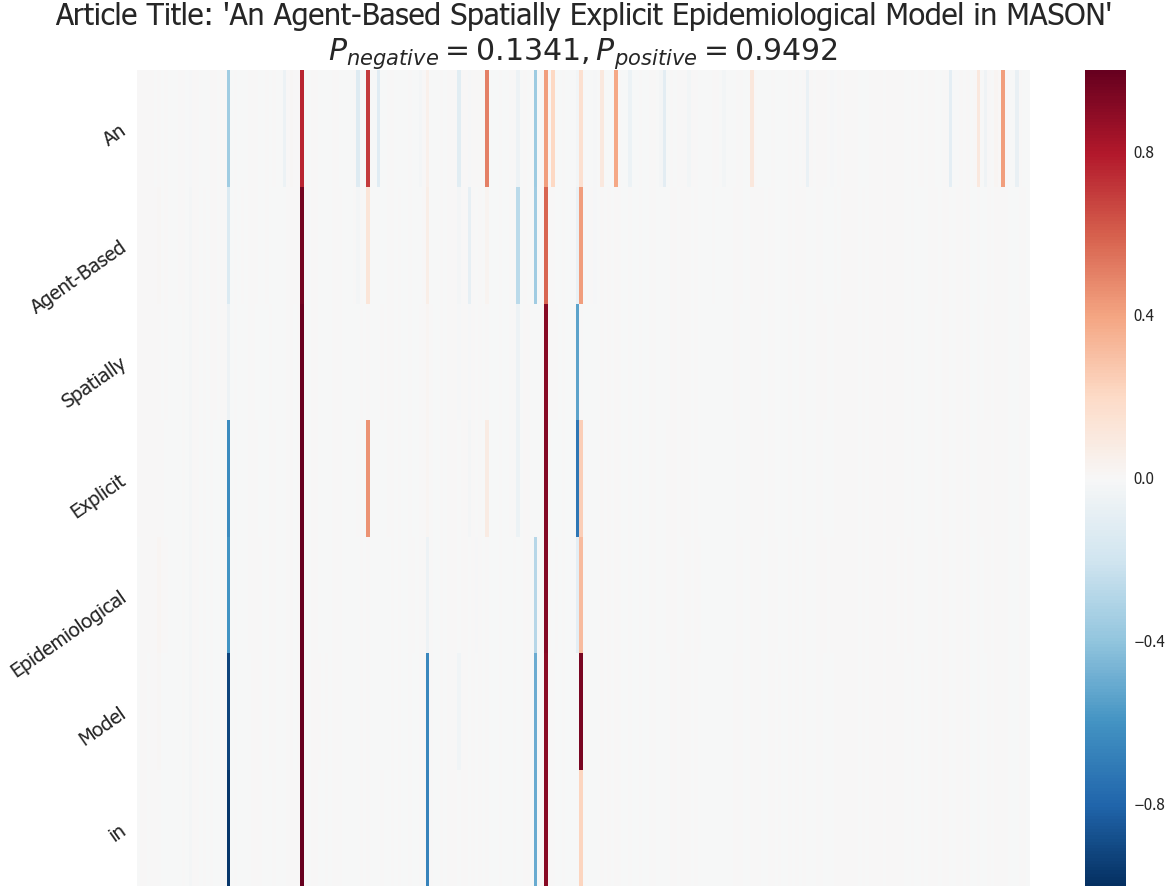

In [27]:
simple_id.compareRows([row_dict], Net)
#plt.savefig('activations.pdf', format = 'pdf')

In [28]:
row_dict['title_tokens']

['exploration', 'of', 'computers', ',', 'tech', 'and', 'r']

# Effects of varying input

In [29]:
for i in range(len(row_dict['title_tokens'])):
    newDict = {
    'abstract' : row_dict['abstract'],
    'abstract_tokens' : row_dict['abstract_tokens'],
    #'title' : row_dict['title'],
    'title_tokens' : row_dict['title_tokens'][:i + 1],   
    }
    pred = Net.predictRow(newDict, w2v=w2v)
    print("propP is: {:.2f}% with title: '{}'".format(pred['probPos'] * 100, ' '.join(newDict['title_tokens'])))

propP is: 95.96% with title: 'exploration'
propP is: 94.36% with title: 'exploration of'
propP is: 96.92% with title: 'exploration of computers'
propP is: 96.38% with title: 'exploration of computers ,'
propP is: 95.90% with title: 'exploration of computers , tech'
propP is: 95.38% with title: 'exploration of computers , tech and'
propP is: 94.47% with title: 'exploration of computers , tech and r'


In [30]:
for i in range(len(row_dict['abstract_tokens'])):
    newDict = {
    'abstract' : row_dict['abstract'],
    'abstract_tokens' : row_dict['abstract_tokens'][:i + 1],
    'title' : row_dict['title'],
    'title_tokens' : row_dict['title_tokens'],   
    }
    pred = Net.predictRow(newDict, w2v=w2v)
    print("propP is: {:.2f}% with abstract only {} sentences long".format(pred['probPos'] * 100, i + 1))

propP is: 74.61% with abstract only 1 sentences long
propP is: 74.97% with abstract only 2 sentences long
propP is: 94.47% with abstract only 3 sentences long


In [31]:
preds1 = []
for i in range(len(row_dict['title_tokens'])):
    predT = []
    for j in range(len(row_dict['abstract_tokens'])):
        newDict = {
            'abstract_tokens' : row_dict['abstract_tokens'][:j+1],
            'title_tokens' : row_dict['title_tokens'][:i + 1],   
            }
        pred = Net.predictRow(newDict, w2v=w2v)
        predT.append(float(pred['probPos']))
    preds1.append(predT)

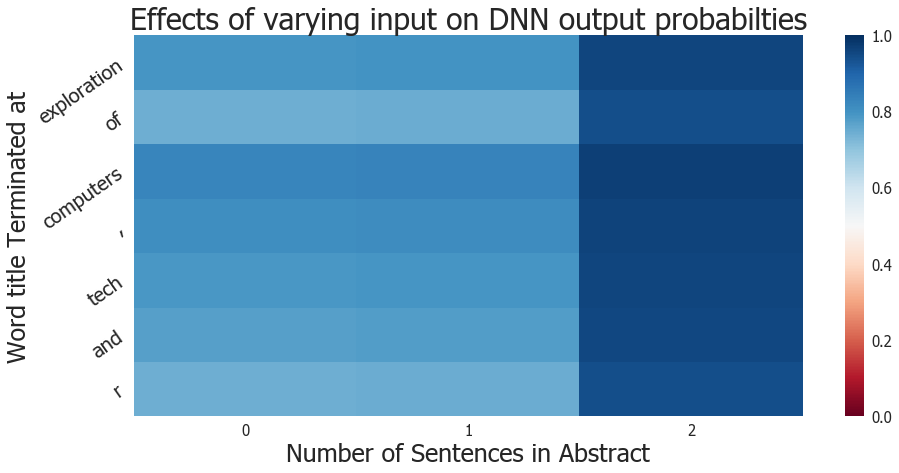

In [32]:
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(preds1, ax = ax, vmin=0, vmax=1, cmap='RdBu')
ax.set_ylabel('Word title Terminated at')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_yticklabels(reversed(row_dict['title_tokens']),rotation = 35, fontsize = 20)
row_dict['title_tokens']
ax.set_title("Effects of varying input on DNN output probabilties");

In [33]:
preds = []
for i in range(len(row_dict['title_tokens'])):
    predT = []
    for j in range(len(row_dict['abstract_tokens'])):
        for k in range(len(row_dict['abstract_tokens'][j])):
            newDict = {
                'abstract_tokens' : row_dict['abstract_tokens'][:j] + [row_dict['abstract_tokens'][j][:k+1]],
                'title_tokens' : row_dict['title_tokens'][:i + 1],   
                }
            pred = Net.predictRow(newDict, w2v=w2v)
            predT.append(float(pred['probPos']))
    print("{:.0f}% done".format(i / len(row_dict['title_tokens']) * 100), end = '\r')
    preds.append(predT)

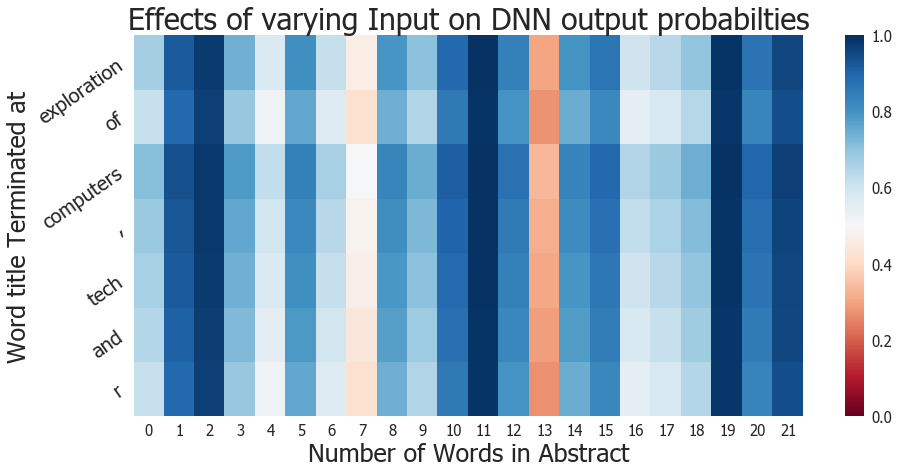

In [34]:
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(preds, ax = ax, vmin=0, vmax=1, cmap='RdBu')
ax.set_ylabel('Word title Terminated at')
ax.set_xlabel('Number of Words in Abstract')
ax.set_yticklabels(reversed(row_dict['title_tokens']),rotation = 35, fontsize = 20)
ax.set_title("Effects of varying Input on DNN output probabilties");

# Interactive Mode Example

In [35]:
title = "Exploration of computers, tech and R"
abstract = 'We used R and Python to do stuff. Then we did more stuff. Our code can be found on Github'
title2 = "Effects of input elaboration on vocabulary acquisition through reading by Korean learners of English as a foreign language"

abstract2 = """This article investigates whether (a) lexical elaboration (LE), typographical enhancement (TE), or a combination, and (b) explicit OF implicit,LE affect 297 Korean learner's acquisition of English vocabulary. The learners were asked to read one of six versions of an experimental text that contained 26 target words. The study adopted a 2 X 3 MANOVA (:design with TE and LE as two independent variables and form- and meaning-recognition vocabulary posttests as two dependent variables. The TE had two levels, enhanced and unenhanced, and the LE lipid three levels, explicit, implicit, and unelaborated. The results were (a) LE alone did not aid form recognition of vocabulary, (b) explicit LE alone aided meaning recognition of vocabulary, (c) TE alone did not aid form and meaning recognition of vocabulary, (d) LE and TE combined did not aid form recognition of vocabulary, (e) both explicit and implicit LE aided meaning recognition of vocabulary, (f) explicit and implicit LE (lid riot differ in their effect on form and meaning recognition of vocabulary, and (g) whether a text was further enhanced in addition to either explicit or implicit LE did not seem to affect the acquisition of the previously Unknown words' forms or meanings."""

In [36]:
title = "Exploration of humans, society and R"
abstract = ' Our code can be found on Github. We used methods and techniques to do stuff. Weber Freud and vocabulary acquisition were explored. Then we did more stuff.'

In [37]:
exampleDict = {
    'title_tokens' : simple_id.tokenizer(title),
    'abstract_tokens' : simple_id.sentinizer(abstract),   
    }
pred = Net.predictRow(newDict, w2v=w2v)
print(float(pred['probPos']))

0.944705069065094


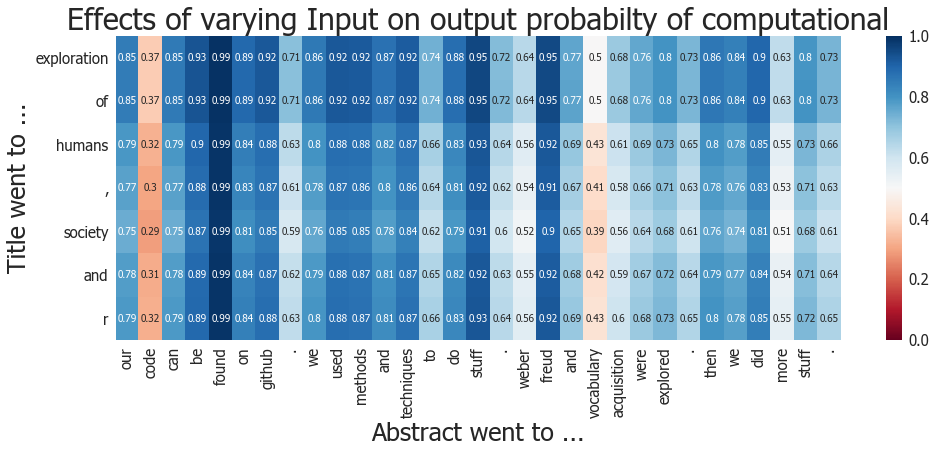

In [49]:
predA = simple_id.makeVarArray(title, abstract,w2vPath, modelFname)
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(predA, ax = ax, vmin=0, vmax=1, cmap='RdBu', annot=True, annot_kws={"size":10})
ax.set_ylabel('Title went to ...')
ax.set_xlabel('Abstract went to ...')
ax.set_title("Effects of varying Input on output probabilty of computational")
fig.tight_layout()
plt.savefig('images/occ.pdf', format='pdf')

In [50]:
exampleDict = {
    'title_tokens' : simple_id.tokenizer(title2),
    'abstract_tokens' : simple_id.sentinizer(abstract2),   
    }
pred = Net.predictRow(exampleDict, w2v=w2v)
print(float(pred['probPos']))

0.14624139666557312


loading model
Tokenizing
W2Ving
Making predictions
Returning


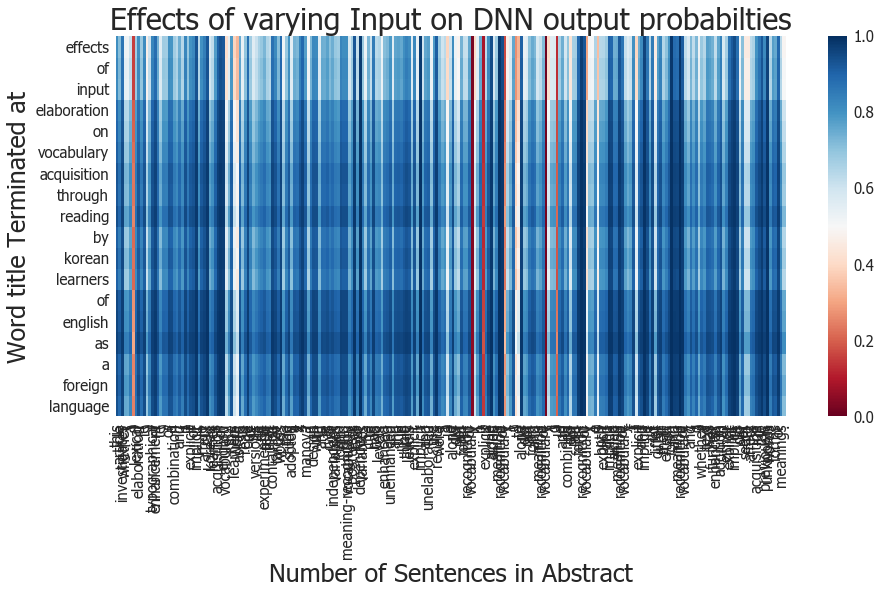

In [51]:
predB = simple_id.makeVarArray(title2, abstract2,w2vPath, modelFname)
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(predB, ax = ax, vmin=0, vmax=1, cmap='RdBu')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_ylabel('Word title Terminated at')
ax.set_title("Effects of varying Input on DNN output probabilties");

In [52]:
title3 = title2
abstract3 = abstract2 + ' Computer github code model python R C software simulation'

exampleDict = {
    'title_tokens' : simple_id.tokenizer(title3),
    'abstract_tokens' : simple_id.sentinizer(abstract3),   
    }
pred = Net.predictRow(exampleDict, w2v=w2v)
print(float(pred['probPos']))

0.6923291087150574


loading model
Tokenizing
W2Ving
Making predictions
Returning


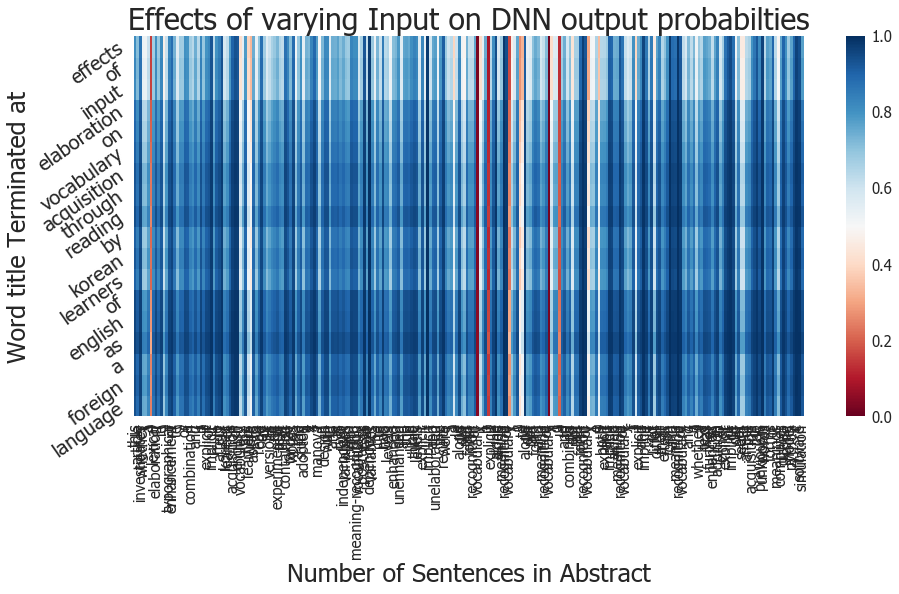

In [53]:
predC = simple_id.makeVarArray(title3, abstract3,w2vPath, modelFname)
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(predC, ax = ax, vmin=0, vmax=1, cmap='RdBu')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_ylabel('Word title Terminated at')
ax.set_yticklabels(reversed(exampleDict['title_tokens']),rotation = 35, fontsize = 20)
ax.set_title("Effects of varying Input on DNN output probabilties");

# Making the images for a bunch of examples

In [ ]:
for i, row in df_sample.iloc[:5].iterrows():
    print(row['title'])
    row_dict = dict(row)
    row_dict['title_tokens'] = Tokens[row_dict['wos_id']][0]
    row_dict['abstract_tokens'] = Tokens[row_dict['wos_id']][1]
    predA = makeVaryingArray(row_dict, Net, w2v)
    fig, ax = plt.subplots(figsize = (15, 7))
    seaborn.heatmap(predA, ax = ax, vmin=0, vmax=1, cmap='RdBu')
    ax.set_xlabel('Number of Sentences in Abstract')
    ax.set_ylabel('Word title Terminated at')
    ax.set_yticklabels(reversed(row_dict['title_tokens']),rotation = 35, fontsize = 20)
    ax.set_title("Effects of varying Input on DNN output probabilties:\n{}".format(row['title']))
    fig.tight_layout()
    plt.savefig('images/pred_var_{}.pdf'.format(row['title'][:50].replace(' ', '_')), format = 'pdf')
    
for i, row in df_sample.iloc[-5:].iterrows():
    print(row['title'])
    predA = makeVaryingArray(row_dict, Net, w2v)
    fig, ax = plt.subplots(figsize = (15, 7))
    seaborn.heatmap(predA, ax = ax, vmin=0, vmax=1, cmap='RdBu')
    ax.set_ylabel('Word title Terminated at')
    ax.set_yticklabels(reversed(row_dict['title_tokens']),rotation = 35, fontsize = 20)
    ax.set_xlabel('Number of Sentences in Abstract')
    ax.set_title("Effects of varying Input on DNN output probabilties:\n{}".format(row['title']))
    fig.tight_layout()
    plt.savefig('images/pred_var_{}.pdf'.format(row['title'][:50].replace(' ', '_').replace('/', '')), format = 'pdf')

# Next steps

+ Get interface with R setup
+ Make interactive
+ Add real explanations
+ Maybe add more modes

Is it truthful?

Is it functional?

Is it beautiful?

Is it insightful?

Is it enlightening?